In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

from sklearn.decomposition import PCA  # Ensure PCA is imported
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans


from mpl_toolkits.mplot3d import Axes3D
data = pd.read_csv(
    "/content/household_power_consumption.txt",
    sep=";",
    na_values=['?', ''],
    low_memory=False)

# Parse datetime column (same as original)
data['datetime'] = pd.to_datetime(
    data['Date'] + ' ' +
    data['Time'],
    dayfirst=True,
    format='%d/%m/%Y %H:%M:%S')
data.drop(['Date', 'Time'], axis=1, inplace=True)

print("Final dataframe matches original structure:\n")
print(data.head())

Final dataframe matches original structure:

   Global_active_power  Global_reactive_power  Voltage  Global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   Sub_metering_1  Sub_metering_2  Sub_metering_3            datetime  
0             0.0             1.0            17.0 2006-12-16 17:24:00  
1             0.0             1.0            16.0 2006-12-16 17:25:00  
2             0.0             2.0            17.0 2006-12-16 17:26:00  
3             0.0             1.0            17.0 2006-12-16 17:27:00  
4             0.0             1.0            17.0 2006-12-16 17:28:00  


In [ ]:
#null pca_result
data_un = data.copy()
missing_values = data_un.isnull().sum()
print("Missing values:\n ", missing_values)

print("\nMissing Precentage:\n", (missing_values / len(data))*100)

Missing values:
  Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
datetime                     0
dtype: int64

Missing Precentage:
 Global_active_power      1.251844
Global_reactive_power    1.251844
Voltage                  1.251844
Global_intensity         1.251844
Sub_metering_1           1.251844
Sub_metering_2           1.251844
Sub_metering_3           1.251844
datetime                 0.000000
dtype: float64


In [ ]:
# Create a new DataFrame with missing values filled
data = data.fillna(data.mean())

# Verify missing values are filled
print("Missing values after filling:\n", data.isnull().sum())

Missing values after filling:
 Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
datetime                 0
dtype: int64


In [ ]:
# Ensure numeric columns have the correct data type,  and not string

numeric_columns = data.columns.drop('datetime')
data[numeric_columns] = data[numeric_columns].apply(pd.to_numeric, errors='coerce')

print(data.dtypes)

Global_active_power             float64
Global_reactive_power           float64
Voltage                         float64
Global_intensity                float64
Sub_metering_1                  float64
Sub_metering_2                  float64
Sub_metering_3                  float64
datetime                 datetime64[ns]
dtype: object


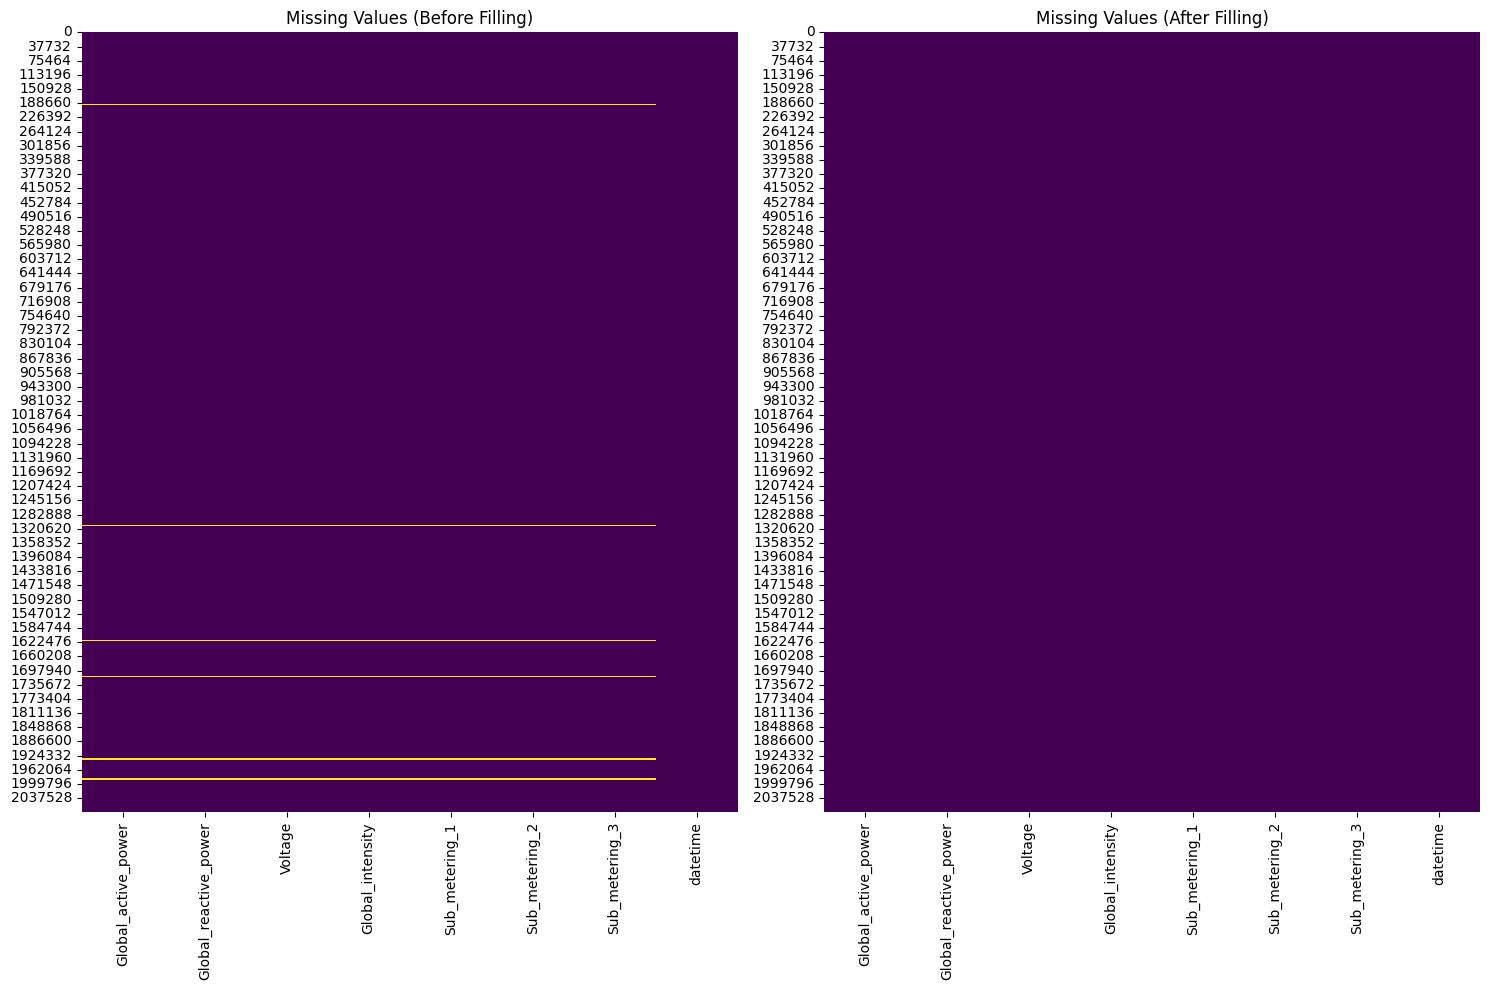

In [ ]:
# Plot heatmaps for missing data

fig, axes = plt.subplots(1,2, figsize=(15,10))

# Heatmap before filling missing values
sns.heatmap(data_un.isnull(), cbar=False, cmap='viridis', ax=axes[0])
axes[0].set_title("Missing Values (Before Filling)")

# Heatmap after filling missing values
sns.heatmap(data.isnull(), cbar=False, cmap='viridis', ax=axes[1])
axes[1].set_title("Missing Values (After Filling)")

plt.tight_layout()
plt.show()

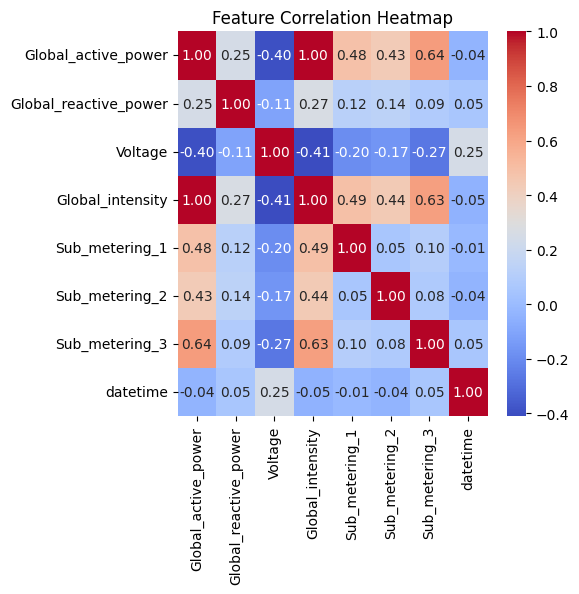

In [ ]:
# Correlation matrix
correlation_matrix = data.corr()

# Plot heatmap of correlations
plt.figure(figsize=(5, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Heatmap")
plt.show()

In [ ]:
# Initialize scaler (range [0,1] is the default)
scaler = MinMaxScaler()

# Normalize all features except datetime
data_scaled = scaler.fit_transform(data.drop(columns=['datetime']))

# Convert back to DataFrame (optional)
data_scaled = pd.DataFrame(data_scaled, columns=data.columns.drop('datetime'))

# Reattach datetime index for time-series context
data_scaled['datetime'] = data['datetime'].values  # Or use .index if datetime is the index

print("Data normalized between 0 and 1 ")

Data normalized between 0 and 1 


In [ ]:
# we need pure numerical features, therefore drop the datetime column
# Separate datetime from features
datetime_column = data_scaled['datetime']  # Preserve datetime for later use
features_scaled = data_scaled.drop(columns=['datetime'])  # Numerical data only

# Example: Retain components covering 95% variance
pca = PCA(n_components=0.95)  # Automatically selects components for 95% variance
pca_result = pca.fit_transform(features_scaled)

print(f"Reduced to {pca.n_components_} components (explains {pca.explained_variance_ratio_.sum()*100:.2f}% variance)")

# Create DataFrame with principal components
pca_df = pd.DataFrame(
    data=pca_result,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)]
)

# Reattach datetime for time-series context
pca_df['datetime'] = data_scaled['datetime'].values

print(pca_df.head())

Reduced to 5 components (explains 98.47% variance)
        PC1       PC2       PC3       PC4       PC5            datetime
0  0.484410 -0.280155  0.013933  0.143574 -0.013831 2006-12-16 17:24:00
1  0.507724 -0.402335  0.035493  0.125213 -0.020051 2006-12-16 17:25:00
2  0.541606 -0.411808  0.039056  0.167662 -0.012417 2006-12-16 17:26:00
3  0.539698 -0.402062  0.049824  0.170293 -0.022437 2006-12-16 17:27:00
4  0.459128 -0.239021  0.030991  0.231682 -0.015820 2006-12-16 17:28:00


In [ ]:
# Separate datetime and features
datetime_column = data_scaled['datetime']
features_scaled = data_scaled.drop(columns=['datetime'])

# Apply PCA with 95% variance threshold
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(features_scaled)

# Print results
print(f"Original features: {features_scaled.shape[1]}")
print(f"Reduced components: {pca.n_components_} (explains {pca.explained_variance_ratio_.sum()*100:.2f}% variance)")

Original features: 7
Reduced components: 5 (explains 98.47% variance)


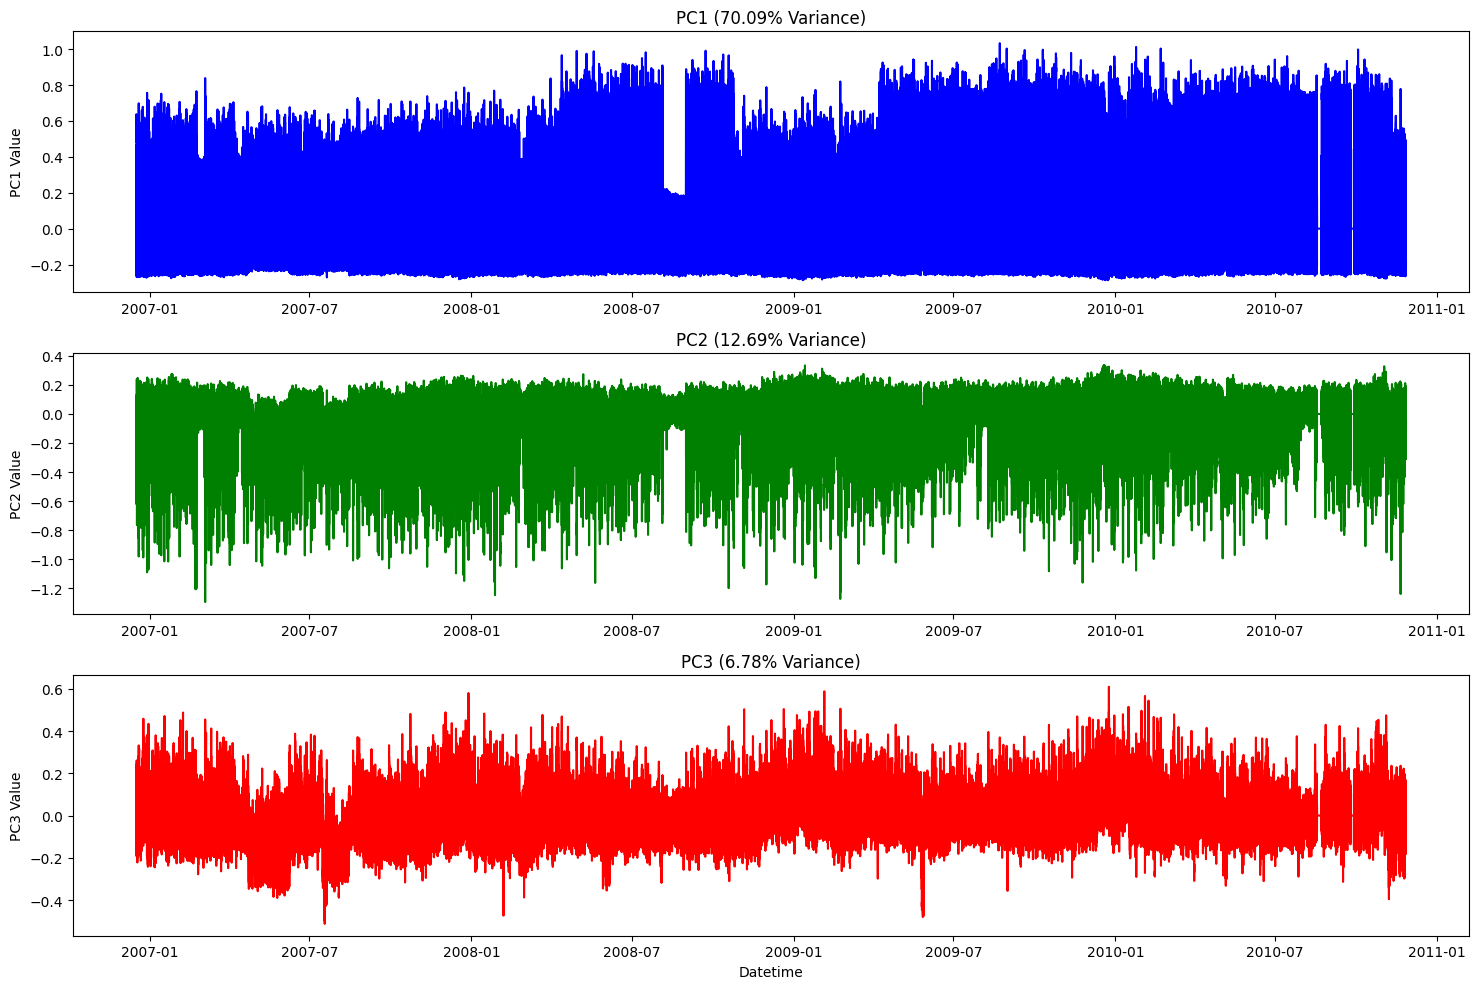

In [ ]:
# Create DataFrame with first 3 components and datetime
pca_df = pd.DataFrame({
    'datetime': datetime_column,
    'PC1': pca_result[:, 0],
    'PC2': pca_result[:, 1],
    'PC3': pca_result[:, 2]
})

# Plotting
plt.figure(figsize=(15, 10))

# Plot PC1
plt.subplot(3, 1, 1)
plt.plot(pca_df['datetime'], pca_df['PC1'], color='blue')
plt.title(f'PC1 ({pca.explained_variance_ratio_[0]*100:.2f}% Variance)')
plt.ylabel('PC1 Value')

# Plot PC2
plt.subplot(3, 1, 2)
plt.plot(pca_df['datetime'], pca_df['PC2'], color='green')
plt.title(f'PC2 ({pca.explained_variance_ratio_[1]*100:.2f}% Variance)')
plt.ylabel('PC2 Value')

# Plot PC3
plt.subplot(3, 1, 3)
plt.plot(pca_df['datetime'], pca_df['PC3'], color='red')
plt.title(f'PC3 ({pca.explained_variance_ratio_[2]*100:.2f}% Variance)')
plt.ylabel('PC3 Value')
plt.xlabel('Datetime')

plt.tight_layout()
plt.show()

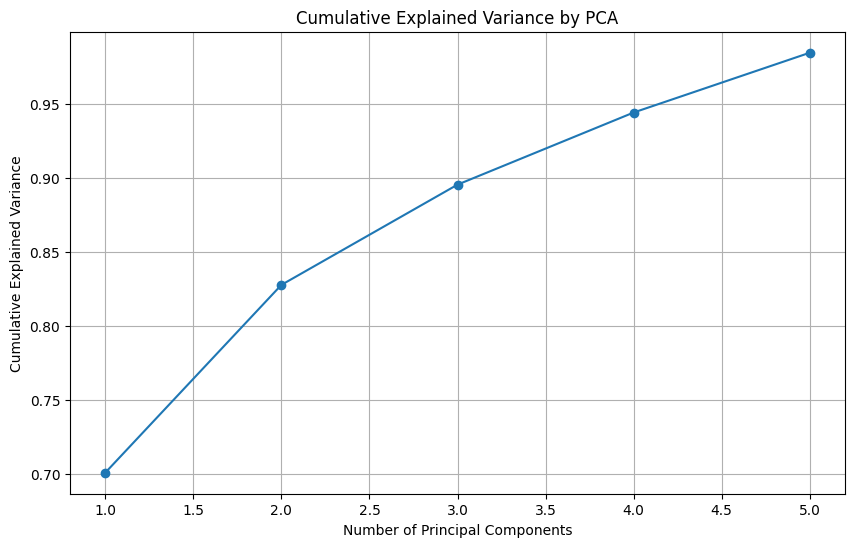

In [ ]:
# Plot cumulative explained variance again
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA')
plt.grid()
plt.show()

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


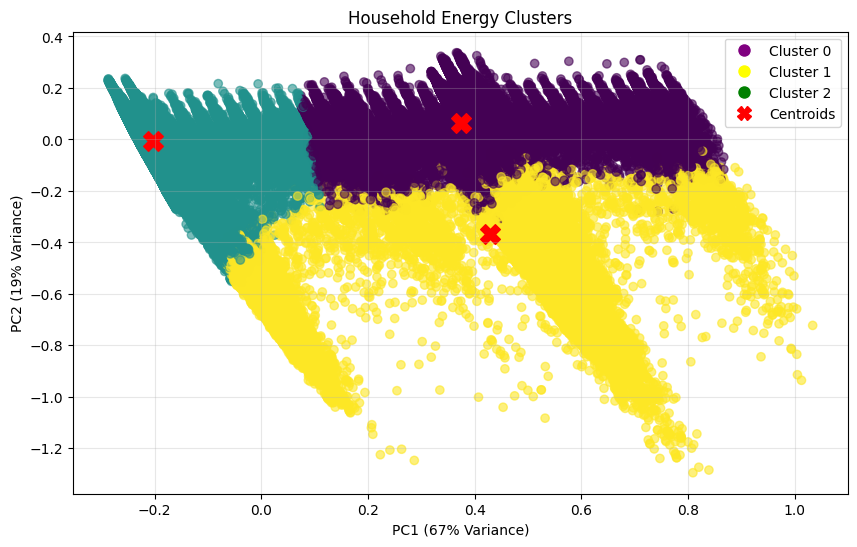

         Global_active_power  Sub_metering_1  Sub_metering_2  Sub_metering_3
Cluster                                                                     
0                   1.756159        0.188516        0.527784       17.893959
1                   0.572603        0.425054        0.769435        0.528767
2                   4.331119       19.019340       15.347356       14.950852


In [ ]:
# Apply K-Means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_result)
data['Cluster'] = clusters

# Create plot
plt.figure(figsize=(10, 6))

# Plot clusters
plt.scatter(pca_result[:,0], pca_result[:,1], c=clusters, cmap='viridis', alpha=0.6,
            label='Data Points')

# Plot centroids
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1],
            s=200, marker='X', c='red', label='Centroids')

# Create custom legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Cluster 0',
               markerfacecolor='purple', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Cluster 1',
               markerfacecolor='yellow', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Cluster 2',
               markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='X', color='red', label='Centroids',
               markersize=10, linestyle='')
]

plt.legend(handles=legend_elements)
plt.xlabel('PC1 (67% Variance)')
plt.ylabel('PC2 (19% Variance)')
plt.title('Household Energy Clusters')
plt.grid(alpha=0.3)
plt.show()

# Show mean values
print(data.groupby('Cluster').mean()[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']])

/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


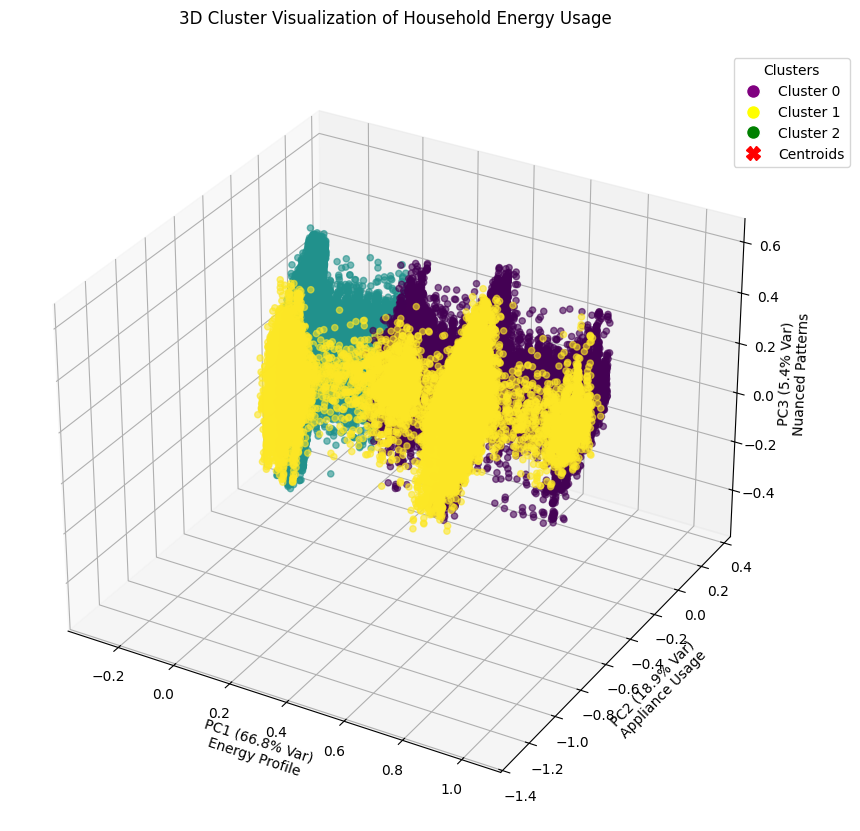

In [ ]:
# Cluster into 3 groups
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_result)

# Create 3D plot
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(111, projection='3d')

# Plot clusters
scatter = ax.scatter(pca_result[:, 0], pca_result[:, 1], pca_result[:, 2],
                    c=clusters, cmap='viridis', alpha=0.6, s=20)

# Plot centroids
centroids = ax.scatter(kmeans.cluster_centers_[:, 0],
                      kmeans.cluster_centers_[:, 1],
                      kmeans.cluster_centers_[:, 2],
                      s=200, marker='X', c='red', label='Centroids')

# Create legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', label='Cluster 0',
               markerfacecolor='purple', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Cluster 1',
               markerfacecolor='yellow', markersize=10),
    plt.Line2D([0], [0], marker='o', color='w', label='Cluster 2',
               markerfacecolor='green', markersize=10),
    plt.Line2D([0], [0], marker='X', color='red', label='Centroids',
               markersize=10, linestyle='')
]

ax.legend(handles=legend_elements, bbox_to_anchor=(1.1, 1), title="Clusters")

# Axis labels with variance percentages
ax.set_xlabel('PC1 (66.8% Var)\nEnergy Profile')
ax.set_ylabel('PC2 (18.9% Var)\nAppliance Usage')
ax.set_zlabel('PC3 (5.4% Var)\nNuanced Patterns')
ax.set_title("3D Cluster Visualization of Household Energy Usage", pad=20)

plt.show()

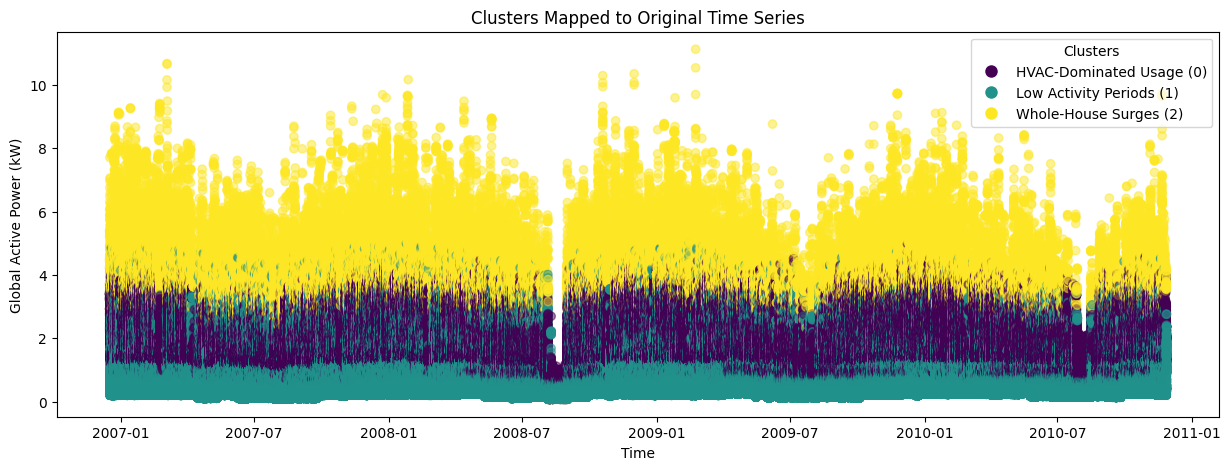

In [ ]:
plt.figure(figsize=(15, 5))
scatter = plt.scatter(data['datetime'], data['Global_active_power'],
                     c=clusters, cmap='viridis', alpha=0.5,
                     label=clusters)  # Add label parameter

# Create custom legend
legend_labels = ['HVAC-Dominated Usage (0)',
                 'Low Activity Periods (1)',
                 'Whole-House Surges (2)']
handles = [plt.Line2D([0], [0], marker='o', color='w',
           markerfacecolor=plt.cm.viridis(i/2), markersize=10)
           for i in range(3)]

plt.xlabel('Time')
plt.ylabel('Global Active Power (kW)')
plt.title('Clusters Mapped to Original Time Series')
plt.legend(handles, legend_labels, title='Clusters')
plt.show()

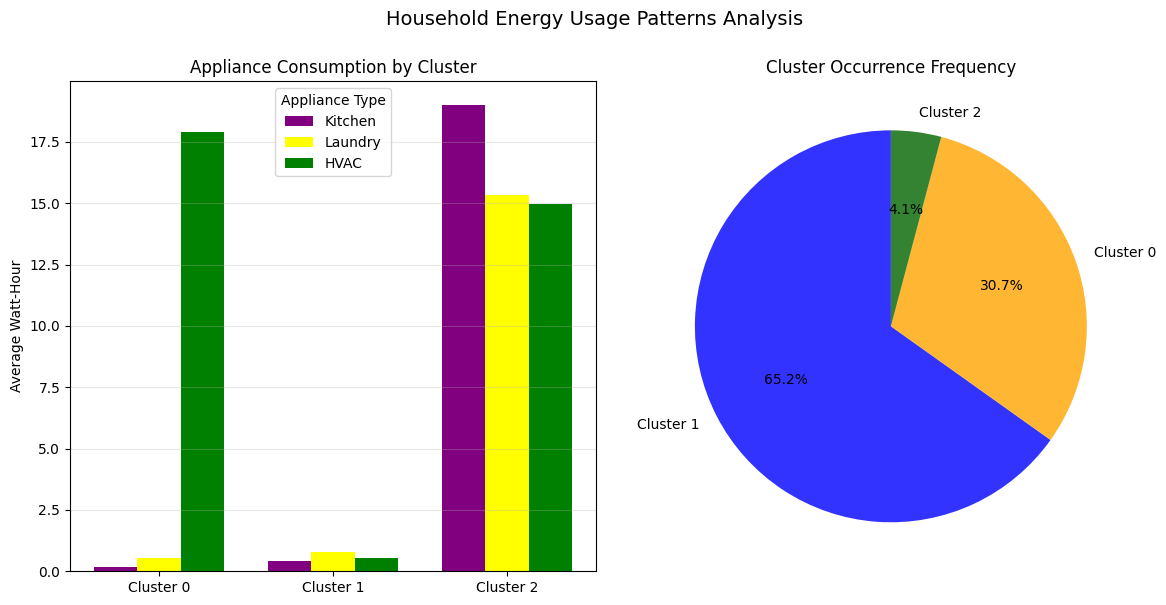

In [ ]:
plt.figure(figsize=(12, 6))  # Adjusted figure size

# 1. Energy Consumption Patterns (Left)
plt.subplot(1, 2, 1)
cluster_means = data.groupby('Cluster')[['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']].mean()
colors = ['purple', 'yellow', 'green']
x = np.arange(3)  # 3 clusters

for i, col in enumerate(['Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']):
    plt.bar(x + i*0.25, cluster_means[col], width=0.25, color=colors[i],
            label=['Kitchen', 'Laundry', 'HVAC'][i])

plt.xticks(x + 0.25, ['Cluster 0', 'Cluster 1', 'Cluster 2'])
plt.ylabel('Average Watt-Hour')
plt.title('Appliance Consumption by Cluster')
plt.legend(title='Appliance Type')
plt.grid(axis='y', alpha=0.3)

# 2. Usage Frequency (Right)
plt.subplot(1, 2, 2)
cluster_counts = data['Cluster'].value_counts()
plt.pie(cluster_counts,
        labels=[f'Cluster {i}' for i in cluster_counts.index],
        colors=['blue', 'orange', 'darkgreen'],
        autopct='%1.1f%%',
        startangle=90,
        wedgeprops={'alpha': 0.8})
plt.title('Cluster Occurrence Frequency')

plt.suptitle('Household Energy Usage Patterns Analysis', fontsize=14, y=1.0)
plt.tight_layout()
plt.show()

<Figure size 2200x800 with 0 Axes>

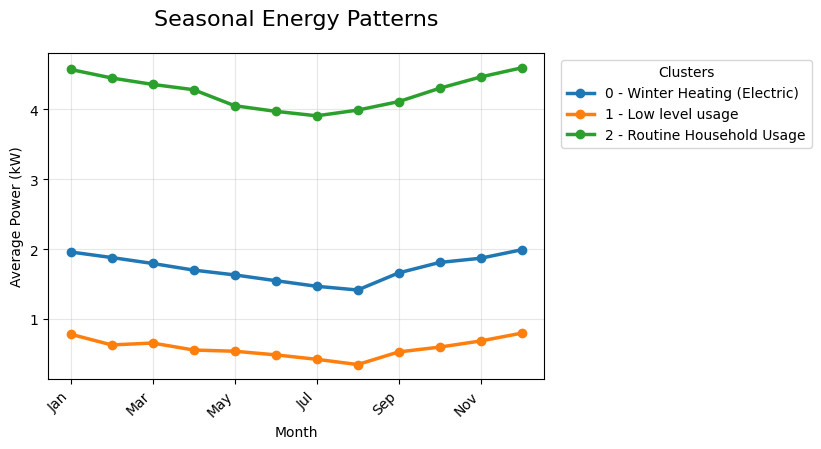

<Figure size 2200x800 with 0 Axes>

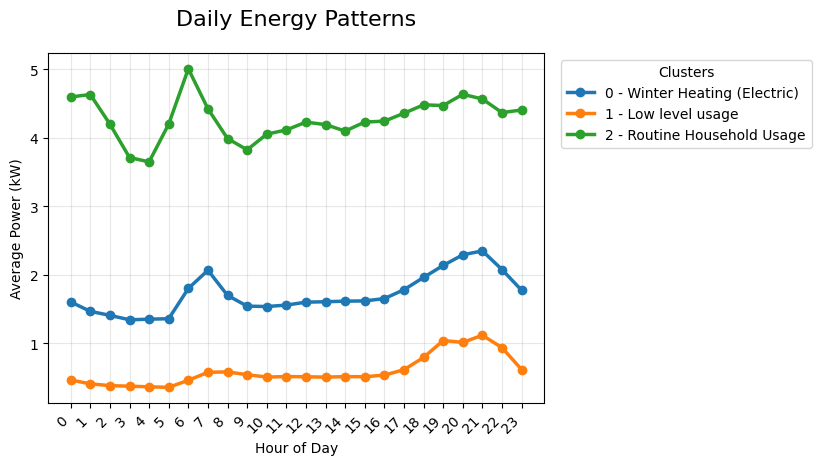

In [ ]:
# Set up cluster naming based on energy patterns
cluster_names = {
    0: "0 - Winter Heating (Electric)",
    1: "1 - Low level usage",
    2: "2 - Routine Household Usage"
}

# Monthly Energy Consumption Analysis
plt.figure(figsize=(22, 8))  # Increased width from 16 to 22 inches

# Calculate monthly means using the 'datetime' column
monthly_energy = data.groupby([data['datetime'].dt.month, 'Cluster'])['Global_active_power'].mean().unstack()

# Convert to month names and reorder clusters
month_order = ['Jan','Feb','Mar','Apr','May','Jun',
               'Jul','Aug','Sep','Oct','Nov','Dec']
cluster_order = [0, 1, 2]  # Winter, Summer, Routine

# Ensure the monthly_energy index uses month names correctly
monthly_energy.index = pd.CategoricalIndex(monthly_energy.index.map(lambda x: month_order[x-1]), categories=month_order, ordered=True)
monthly_energy = monthly_energy.loc[month_order]
monthly_energy = monthly_energy[cluster_order]

# Create visualization
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Winter blue, Summer orange, Routine green
monthly_energy.plot(kind='line', marker='o', color=colors, linewidth=2.5)

plt.title('Seasonal Energy Patterns', fontsize=16, pad=20)
plt.xlabel('Month')
plt.ylabel('Average Power (kW)')
plt.legend([cluster_names[k] for k in cluster_order],
           title='Clusters',
           bbox_to_anchor=(1.02, 1))
plt.grid(alpha=0.3)
plt.xticks(rotation=45, ha='right')  # Added horizontal alignment
plt.subplots_adjust(bottom=0.2)
plt.show()

# Hourly Energy Consumption Analysis
# ----------------------------------
plt.figure(figsize=(22, 8))  # Increased width from 16 to 22 inches

# Calculate hourly means using the 'datetime' column
hourly_energy = data.groupby([data['datetime'].dt.hour, 'Cluster'])['Global_active_power'].mean().unstack()[cluster_order]

# Create visualization
hourly_energy.plot(kind='line', marker='o', color=colors, linewidth=2.5)

plt.title('Daily Energy Patterns', fontsize=16, pad=20)
plt.xlabel('Hour of Day')
plt.ylabel('Average Power (kW)')
plt.xticks(range(0, 24), rotation=45, ha='right')  # Added horizontal alignment
plt.legend([cluster_names[k] for k in cluster_order],
           title='Clusters',
           bbox_to_anchor=(1.02, 1))
plt.grid(alpha=0.3)

plt.subplots_adjust(bottom=0.15)
plt.show()